Initial data shape: (11, 2)

First few rows:
     Gender                       Gender ; Male - 1, Female -0
0        cp                                    Chest pain type
1  trestbps                             Resting blood pressure
2      chol                                cholesterol measure
3       fbs  (fasting blood sugar > 120 mg/dl) (1 = true; 0...
4   restecg  ecg observation at resting condition,   -- Val...

Column names:
['Gender', 'Gender ; Male - 1, Female -0']

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        11 non-null     object
 1   Gender ; Male - 1, Female -0  11 non-null     object
dtypes: object(2)
memory usage: 308.0+ bytes
None

First few data rows:
     Gender                       Gender ; Male - 1, Female -0
0        cp                

KeyError: 'age'

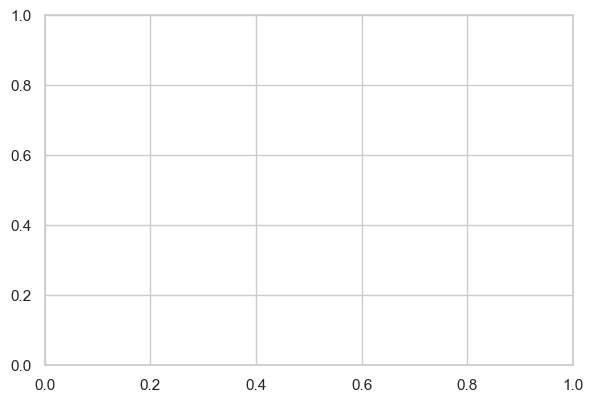

In [5]:
# ================================
# Decision Tree Classification - Optimized Pipeline (Single Cell)
# ================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- SETTINGS ---
sns.set(style="whitegrid")
RANDOM_STATE = 42

# --- TASK 1: DATA LOADING ---
# Try reading with skiprows to skip metadata/header rows
# Try different skiprows until the columns are correct
# Try loading without skiprows first to inspect the columns
# Try reading with header at row 1 (adjust if needed)
df = pd.read_excel(
    "C:/Users/Shreyas Mahale/Downloads/Decision Tree/Decision Tree/heart_disease.xlsx",
    header=1
)

print("Initial data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

# If columns are not correct, try different skiprows values
# For example, try skiprows=0, skiprows=1, ..., until you see the correct columns
# Uncomment and adjust as needed:
# df = pd.read_excel(
#     "C:/Users/Shreyas Mahale/Downloads/Decision Tree/Decision Tree/heart_disease.xlsx",
#     skiprows=10
# )
# print(df.columns.tolist())

# Drop fully empty rows
df = df.dropna(how="all").reset_index(drop=True)

# Convert key numeric columns
numeric_cols = ["age", "trestbps", "chol", "thalch", "oldpeak"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop again rows that are completely NaN
df = df.dropna(how="all").reset_index(drop=True)

print("\nCleaned dataset info:")
print(df.info())
print("\nFirst few data rows:")
print(df.head())

# --- TASK 2: EDA ---
print("\nMissing Values:\n", df.isnull().sum())

# Replace 0 in known invalid numeric columns with NaN
for col in ["chol", "trestbps"]:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df["age"].astype(float), kde=True)
plt.title("Age Distribution")

plt.subplot(2, 2, 2)
sns.boxplot(x="num", y="thalch", data=df)  # thalch is numeric now
plt.title("Max Heart Rate vs Target")

plt.subplot(2, 2, 3)
sns.countplot(x="cp", hue="num", data=df)
plt.title("Chest Pain Type vs Target")

plt.subplot(2, 2, 4)
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

# --- TASK 3: ENCODING & FEATURE PREP ---
encoder = LabelEncoder()
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

for col in categorical_features:
    if col in df.columns:
        df[col] = encoder.fit_transform(df[col].astype(str))

if "num" not in df.columns:
    raise KeyError("Target column 'num' is missing from the dataset")

X = df.drop("num", axis=1)
y = df["num"]

# Optional binary target (uncomment if needed)
# y = (y > 0).astype(int)

# --- TASK 4: TRAIN-TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- TASK 5: HYPERPARAMETER TUNING WITH GRIDSEARCH ---
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# --- TASK 6: MODEL TRAINING & EVALUATION ---
best_dt = grid_search.best_estimator_

# Predictions
y_pred_train = best_dt.predict(X_train_scaled)
y_pred_test = best_dt.predict(X_test_scaled)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- TASK 7: FEATURE IMPORTANCE ---
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# --- TASK 8: TREE VISUALIZATION ---
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X.columns.tolist(), class_names=['No Disease', 'Disease'], filled=True)
plt.title('Decision Tree Visualization')
plt.tight_layout()
plt.show()